In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Importing ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


# Importing Time Series Models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from prophet import Prophet
import ace_tools_open as tools

In [10]:
# Load Merged Data
csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
#  Technical Indicators
def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()

In [12]:
# Apply Technical Indicators
df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)


In [ ]:
# Target Variable
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)

# Feature Selection & Target
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", 
                "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

X = df[feature_cols]
y = df[target]

In [ ]:
#  Handle NaNs & Scaling
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

scaler_X = RobustScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()


/var/folders/9s/rbms445x16jfp1dzz9z6zkl00000gn/T/ipykernel_19822/622510964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/9s/rbms445x16jfp1dzz9z6zkl00000gn/T/ipykernel_19822/622510964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


In [ ]:
#  Train-Test Split (Consistent for All Models)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


In [ ]:
#  Function to Train & Evaluate Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred

In [ ]:
#  LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1)
])

lstm_model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse, lstm_r2 = sqrt(mean_squared_error(y_test, y_pred_lstm)), r2_score(y_test, y_pred_lstm)


/Users/shobians./Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5894
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [ ]:
#  Convert Predictions Back to Actual Prices
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_lstm_actual = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()


In [ ]:
#  Prophet Model for Forecasting
df_prophet = df[["Date", "Close_Price"]].rename(columns={"Date": "ds", "Close_Price": "y"})
prophet_model = Prophet()
prophet_model.fit(df_prophet)

01:35:55 - cmdstanpy - INFO - Chain [1] start processing
01:36:01 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Create Future Dataframe for Prediction
future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

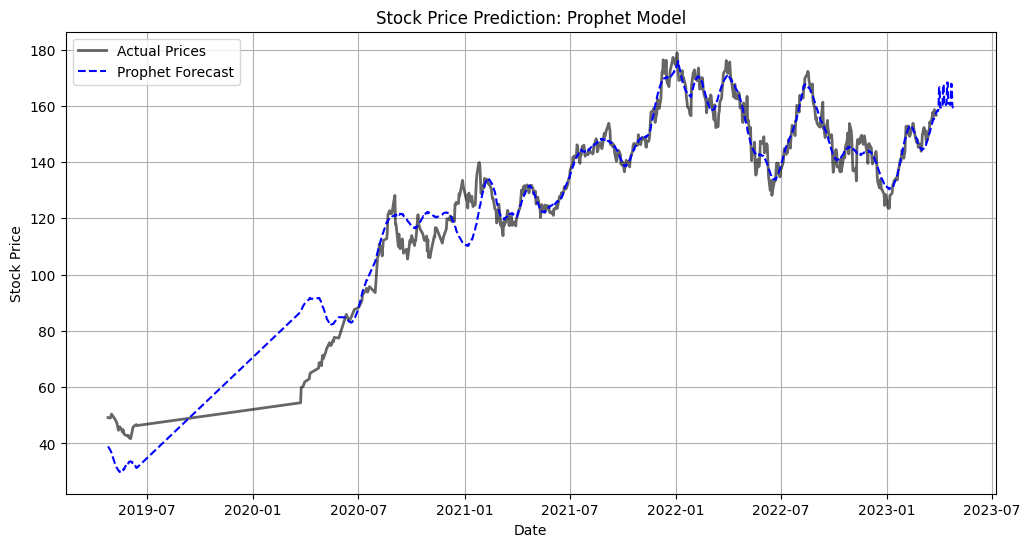

In [ ]:
#  Plot Prophet Forecast vs Actual Data
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual Prices", color="black", linewidth=2, alpha=0.6)
plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], label="Prophet Forecast", linestyle="dashed", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Prophet Model")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=700, learning_rate=0.5, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf')
}

In [23]:
# Evaluate All Models
model_results = {}
model_predictions = {}

for model_name, model in models.items():
    rmse, r2, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_results[model_name] = (rmse, r2)
    model_predictions[model_name] = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 12758, number of used features: 9
[LightGBM] [Info] Start training from score 0.764805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
#  Performance Comparison
results_df = pd.DataFrame(model_results, index=["RMSE", "R²"]).T
results_df.loc["LSTM"] = [lstm_rmse, lstm_r2]



Model Performance


/var/folders/9s/rbms445x16jfp1dzz9z6zkl00000gn/T/ipykernel_19822/2255469066.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="Blues_d")


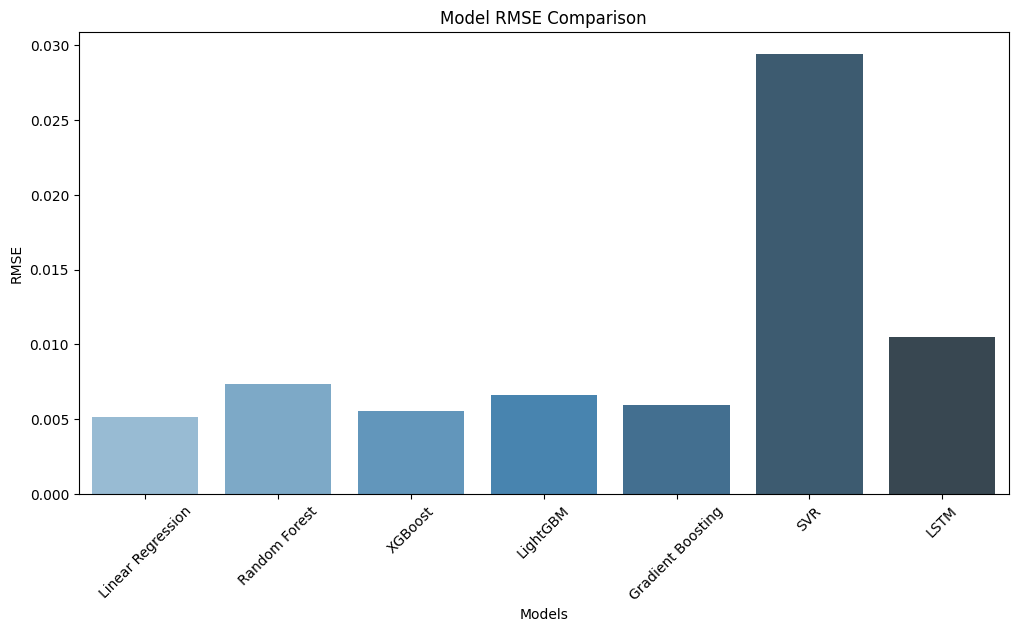

/var/folders/9s/rbms445x16jfp1dzz9z6zkl00000gn/T/ipykernel_19822/2255469066.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["R²"], palette="Reds_d")


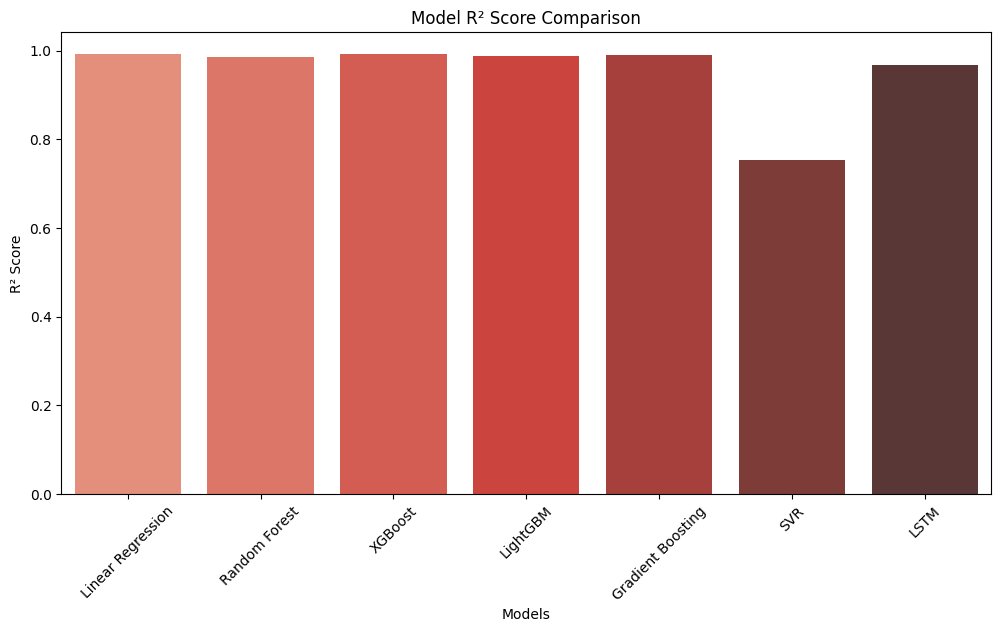

In [ ]:
#  Visualization
tools.display_dataframe_to_user(name="Model Performance", dataframe=results_df)

#  Plot RMSE & R² Score Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="Blues_d")
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["R²"], palette="Reds_d")
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("R² Score")
plt.title("Model R² Score Comparison")
plt.show()
